In [1]:
import pandas as pd
from lifetimes import BetaGeoFitter
from lifetimes.utils import summary_data_from_transaction_data

client_features = pd.read_csv('client_features.csv')

df =  pd.read_csv('data_cleaned.csv')
# Prepare data for Lifetimes
data_summary = summary_data_from_transaction_data(
    df, 
    customer_id_col='ID Client', 
    datetime_col='Date Commande',
    monetary_value_col='Total'
)

# Fit BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=0.01) # Adjust if needed
bgf.fit(
    data_summary['frequency'], 
    data_summary['recency'], 
    data_summary['T']
)

# Predict CLV over the next 12 months
# Calculate expected number of future purchases
t = 12  # time in months
expected_purchases = bgf.conditional_expected_number_of_purchases_up_to_time(t, data_summary['frequency'], data_summary['recency'], data_summary['T'])

# Calculate average order value
avg_order_value = data_summary['monetary_value'].mean()

# Estimate CLV
clv_12_months = expected_purchases * avg_order_value

# Display CLV in a new DataFrame
clv_results = pd.DataFrame({
    'ID Client': data_summary.index,
    'Predicted CLV (12 months)': clv_12_months.values
})

# Display CLV in a new DataFrame
clv_results = pd.DataFrame({
    'ID Client': clv_12_months.index,
    'Predicted CLV (12 months)': clv_12_months.values
})


# Format CLV column to a readable number format
clv_results['Predicted CLV (12 months)'] = clv_results['Predicted CLV (12 months)'].map('{:,.2f}'.format)
 
print(clv_results)

     ID Client Predicted CLV (12 months)
0            1                 49,898.18
1            2                 13,870.92
2            3                  9,292.42
3            4                  6,637.74
4            5                      0.00
..         ...                       ...
930       1382                  2,698.65
931       1383                  2,485.93
932       1386                  9,817.10
933       1389                  6,100.18
934       1393                 11,941.80

[935 rows x 2 columns]


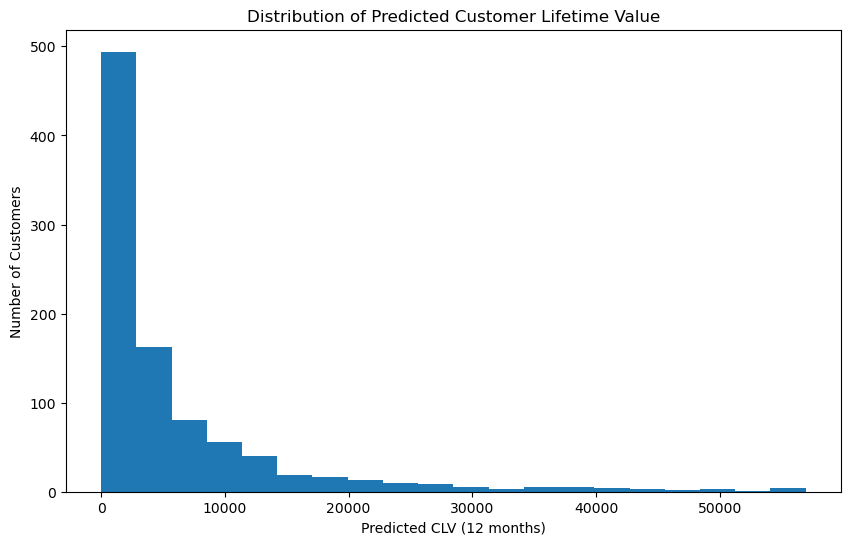

In [2]:
import matplotlib.pyplot as plt

# ... your existing code ...

# Plot CLV distribution
plt.figure(figsize=(10, 6))
plt.hist(clv_12_months, bins=20)
plt.xlabel('Predicted CLV (12 months)')
plt.ylabel('Number of Customers')
plt.title('Distribution of Predicted Customer Lifetime Value')
plt.show()


In [3]:
# Create CLV segments
# Calculate expected number of future purchases
t = 12  # time in months
expected_purchases = bgf.conditional_expected_number_of_purchases_up_to_time(t, data_summary['frequency'], data_summary['recency'], data_summary['T'])

# Calculate average order value
avg_order_value = data_summary['monetary_value'].mean()

# Estimate CLV
clv_12_months = expected_purchases * avg_order_value

# Display CLV in a new DataFrame
clv_results = pd.DataFrame({
    'ID Client': data_summary.index,
    'Predicted CLV (12 months)': clv_12_months.values
})

# Create CLV segments
client_features['CLV_Segment'] = pd.qcut(clv_results['Predicted CLV (12 months)'], q=3, labels=["Low", "Medium", "High"])

# Group by CLV segment and calculate mean values
cluster_summary = client_features.groupby('CLV_Segment')[['Total Orders', 'Average Order Value', 'Unique Products Purchased', 'Time Since First Purchase', 'Time Since Last Purchase', 'Purchase Frequency']].mean()

# Print the summary table
print(cluster_summary.round(2))
cluster_summary

             Total Orders  Average Order Value  Unique Products Purchased  \
CLV_Segment                                                                 
Low                 18.28              1861.53                     120.74   
Medium              22.37              1374.54                     184.01   
High               147.56               848.94                     689.51   

             Time Since First Purchase  Time Since Last Purchase  \
CLV_Segment                                                        
Low                             630.07                    414.22   
Medium                          656.78                    188.21   
High                            713.28                    149.94   

             Purchase Frequency  
CLV_Segment                      
Low                      197.67  
Medium                    42.81  
High                      10.81  


,Total Orders,Average Order Value,Unique Products Purchased,Time Since First Purchase,Time Since Last Purchase,Purchase Frequency
CLV_Segment,,,,,,
Low,18.278846,1861.529731,120.737179,630.070513,414.221154,197.670962
Medium,22.369775,1374.539389,184.012862,656.784566,188.209003,42.812472
High,147.557692,848.944770,689.512821,713.282051,149.942308,10.809347


Segment à forte valeur (CLV élevée) :

Volume de commandes extrêmement élevé : Ce segment passe beaucoup plus de commandes que les autres, indiquant un engagement et une fidélité élevés.
Valeur moyenne des commandes plus faible et fréquence d'achat plus faible : Bien qu'ils commandent plus fréquemment, la valeur moyenne de leurs commandes et leurs dépenses par produit sont inférieures.
Achats diversifiés : Ils achètent une plus grande variété de produits, ce qui suggère qu'ils sont peut-être plus ouverts à l'exploration de nouvelles offres.

Segment à valeur moyenne (CLV moyenne) :

Volume et fréquence d'achat modérés : Ils commandent moins fréquemment que le segment Élevé, mais plus souvent que le segment Faible.
Valeur moyenne des commandes plus élevée : Leurs commandes ont tendance à avoir une valeur plus élevée que celles du segment Élevé, peut-être en raison de l'achat d'articles plus chers ou en vrac.
Moins de diversité de produits : Ils achètent une gamme de produits plus étroite que le segment Élevé.

Segment à faible valeur (faible CLV) :

Volume de commandes et produits uniques les plus faibles : Ils passent le moins de commandes et achètent la moindre variété de produits.
Valeur moyenne des commandes la plus élevée : Bien que peu fréquentes, leurs commandes ont la valeur moyenne la plus élevée. Cela pourrait indiquer des achats occasionnels d'articles coûteux.
Risque de désabonnement élevé : Ils sont inactifs depuis un temps considérable, ce qui les rend plus susceptibles de se désabonner.

Segment à forte valeur :

Mettre l'accent sur la fidélisation : Ce sont vos clients les plus fidèles et les plus engagés. Donnez la priorité à la satisfaction client et créez des programmes pour récompenser la fidélité.
Élargir les offres de produits : Étant donné leur volonté d'explorer, introduisez de nouveaux produits ou catégories pour répondre à leurs intérêts.
Vente incitative/Vente croisée : Encouragez les commandes plus importantes en recommandant des produits complémentaires ou en offrant des remises sur volume.

Segment à valeur moyenne :

Engagement et vente incitative : Entretenez ce segment en suggérant des produits connexes ou en proposant des promotions sur des articles plus chers pour augmenter la valeur moyenne de leurs commandes.
Surveiller le risque de désabonnement : Surveillez tout signe de diminution de la fréquence ou de la valeur des commandes afin de lutter de manière proactive contre le risque de désabonnement.

Segment à faible valeur :

Campagnes de réengagement : Développez des campagnes ciblées (par exemple, des remises spéciales, des recommandations personnalisées) pour les encourager à effectuer un autre achat.
Analyser les raisons de l'inactivité : Cherchez à comprendre pourquoi ils sont devenus inactifs. Était-ce le prix, la sélection de produits ou d'autres facteurs ?
Perte potentielle : Si le réengagement échoue, envisagez de concentrer vos ressources sur l'acquisition de nouveaux clients ayant un potentiel de valeur plus élevé.